In [240]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from config import get_from_config
import fur.path_assistant as path_assistant
shift = path_assistant.PathAssistant('shift_03_16_2020')
from wiggler_radiation.number_of_coherent_modes.coherent_modes import get_M_interpolator_at_fixed_energy
cur_to_sum_channel = get_from_config("Beam_current_to_Sum_channel_ampl_V/mA")
sum_channel_to_photoelectrons = get_from_config('sum_channel_to_photoelectrons')
N_to_I = 1/sum_channel_to_photoelectrons/cur_to_sum_channel
meas_ROUND = pd.read_csv(shift.get_results_dir().fi('meas_ROUND_03_16_2020.csv'), index_col=0)
meas_ROUND = meas_ROUND.sort_values(by='N',ignore_index=True)

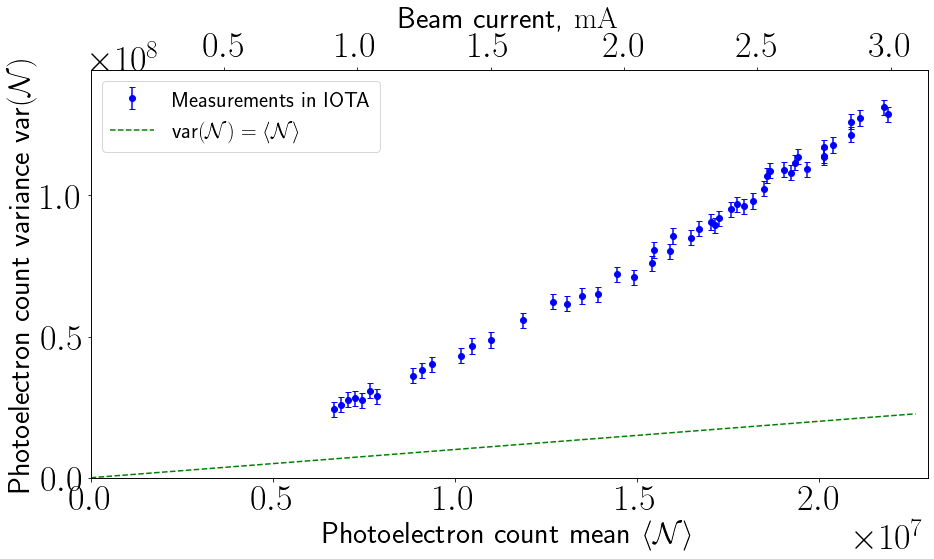

In [241]:
plt.rcParams["text.usetex"] =True
plt.rc('text.latex', preamble=r'\usepackage{siunitx}')
plt.rcParams.update({'font.size': 36,'legend.fontsize':22})
colors = {"FLAT": 'blue'}

fig, ax = plt.subplots(figsize=(15, 7.5))
ax.errorbar(meas_ROUND['N'],meas_ROUND['varN'],marker='o',linestyle='None',
            yerr=meas_ROUND['errorbar'],color='b',
            label = r'Measurements in IOTA')
x_aux = np.linspace(0, ax.get_xlim()[1],100)
ax.plot(x_aux, x_aux,color='green',linestyle='--',
        label = r"var$\left(\mathcal{N}\right)=\langle\mathcal{N}\rangle$")
ax.set_ylabel(r"Photoelectron count variance var$\left(\mathcal{N}\right)$")
ax.set_xlabel(r"Photoelectron count mean $\langle\mathcal{N}\rangle$")
handles, labels = ax.get_legend_handles_labels()
order = [1,0]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
ax.set_xlim(0, 1.05*meas_ROUND['N'].max())
ax.set_ylim(0, 1.1*meas_ROUND['varN'].max())
ax1 = ax.twiny()
ax1.set_xlabel('Beam current, \SI{}{mA}')
ax1.set_xlim(N_to_I*np.asarray(ax.get_xlim()))
ax1.set_xticks(ticks=ax1.get_xticks()[1:-1])
plt.show()

In [242]:
df = pd.read_csv("M_on_grid_precalc.csv", index_col=0)

In [243]:
df.head()

,0.06,0.06857142857142857,0.07714285714285714,0.08571428571428573,0.09428571428571428,0.10285714285714287,0.11142857142857143,0.12
6.693879e+06,2.221984e+06,2.478707e+06,2.738453e+06,3.001321e+06,3.267457e+06,3.536921e+06,3.809616e+06,4.085455e+06
6.868607e+06,2.232259e+06,2.489990e+06,2.750771e+06,3.014674e+06,3.281838e+06,3.552339e+06,3.826136e+06,4.103022e+06
7.057312e+06,2.243369e+06,2.502187e+06,2.764074e+06,3.029091e+06,3.297380e+06,3.569039e+06,3.843973e+06,4.122039e+06
7.249983e+06,2.254729e+06,2.514671e+06,2.777677e+06,3.043832e+06,3.313292e+06,3.586113e+06,3.862211e+06,4.141467e+06
7.445827e+06,2.266292e+06,2.527336e+06,2.791512e+06,3.058828e+06,3.329460e+06,3.603451e+06,3.880718e+06,4.161206e+06


In [244]:
es = df.columns.values.astype(np.float64)

In [245]:
es

array([0.06      , 0.06857143, 0.07714286, 0.08571429, 0.09428571,
       0.10285714, 0.11142857, 0.12      ])

In [246]:
def reconstruct_e(avN, varN):
    Mexp = avN**2/(varN-avN)
    return np.interp(Mexp,df.loc[avN,:],es)

In [247]:
reconstruct_e(meas_ROUND['N'][0], meas_ROUND['varN'][0]+0.01e8)

0.06625254563615697

In [248]:
reconstruct_e(meas_ROUND['N'][0], meas_ROUND['varN'][0])

0.07079722174946498

In [249]:
meas_ROUND['e_rec'] = meas_ROUND.apply(
    lambda row: reconstruct_e(*row[['N', 'varN']]), axis=1)
meas_ROUND['varNtop'] = meas_ROUND['varN']+meas_ROUND['errorbar']
meas_ROUND['varNbottom'] = meas_ROUND['varN']-meas_ROUND['errorbar']
meas_ROUND['e_error_top'] = meas_ROUND.apply(
    lambda row: reconstruct_e(
        *row[['N', 'varNbottom']]), axis=1)\
        - meas_ROUND['e_rec']
meas_ROUND['e_error_bottom'] = -meas_ROUND.apply(
    lambda row: reconstruct_e(
        *row[['N', 'varNtop']]), axis=1)\
        + meas_ROUND['e_rec']

In [250]:
meas_ROUND['I_mA'] = meas_ROUND['N']*N_to_I

In [251]:
# calculation of reconstructed sy
from lattice.summary_in_undulator import CalcTransverseBeamParams
import lattice.lattice as lattice
lattice_df = \
    lattice.read_lattice_file(shift.get_6dsim_dir()\
    .fi("IOTA_1NL_100MeV_v8.6.1.4.6ds_data.txt"))
from scipy.interpolate import interp1d
bp_df = pd.read_csv(shift.get_results_dir().fi("beam_params_vs_current_round.csv"))
ex_func = interp1d(bp_df["N"], bp_df['ex_um'],
                   bounds_error=False, fill_value="extrapolate")
dpp_func = interp1d(bp_df["N"], bp_df['dp/p'],
                    bounds_error=False, fill_value="extrapolate")
# def get_sy(row):
#     Sx, Sy, dx, dy, sxp, syp = CalcTransverseBeamParams(
#         lattice_df, ex_func(row['N']), row['ey_rec'], dpp_func(row['N']))
#     return np.sqrt(Sy**2+syp**2*dy**2)
# meas_FLAT["sy_rec"] = meas_FLAT.apply(get_sy, axis=1)

In [252]:
# # save new meas_FLAT with ey and I_mA
# meas_FLAT.to_csv(shift.get_results_dir().fi('meas_FLAT_03_16_2020.csv'))

In [253]:
round_df = pd.read_csv(shift.get_results_dir().fi("full_beam_params_vs_current_round.csv"))

In [254]:
meas_FLAT = pd.read_csv(shift.get_results_dir().fi('meas_FLAT_03_16_2020.csv'), index_col=0)

In [255]:
flat_df = pd.read_csv(shift.get_results_dir().fi("full_beam_params_vs_current_flat.csv"),
                     index_col=0)

In [256]:
from scipy.interpolate import interp1d
bp_df = pd.read_csv(
    shift.get_results_dir().fi("beam_params_vs_current_round.csv"))
ex_r_func = interp1d(bp_df["N"], bp_df['ex_um'],
                   bounds_error=False, fill_value="extrapolate")
ey_r_func = interp1d(bp_df["N"], bp_df['ey_um'],
                   bounds_error=False, fill_value="extrapolate")
bp_df = pd.read_csv(
    shift.get_results_dir().fi("beam_params_vs_current_flat.csv"))
ex_f_func = interp1d(bp_df["N"], bp_df['ex_um'],
                   bounds_error=False, fill_value="extrapolate")

Remember that a small protion of SLM data at large Ibeam is extrapolated


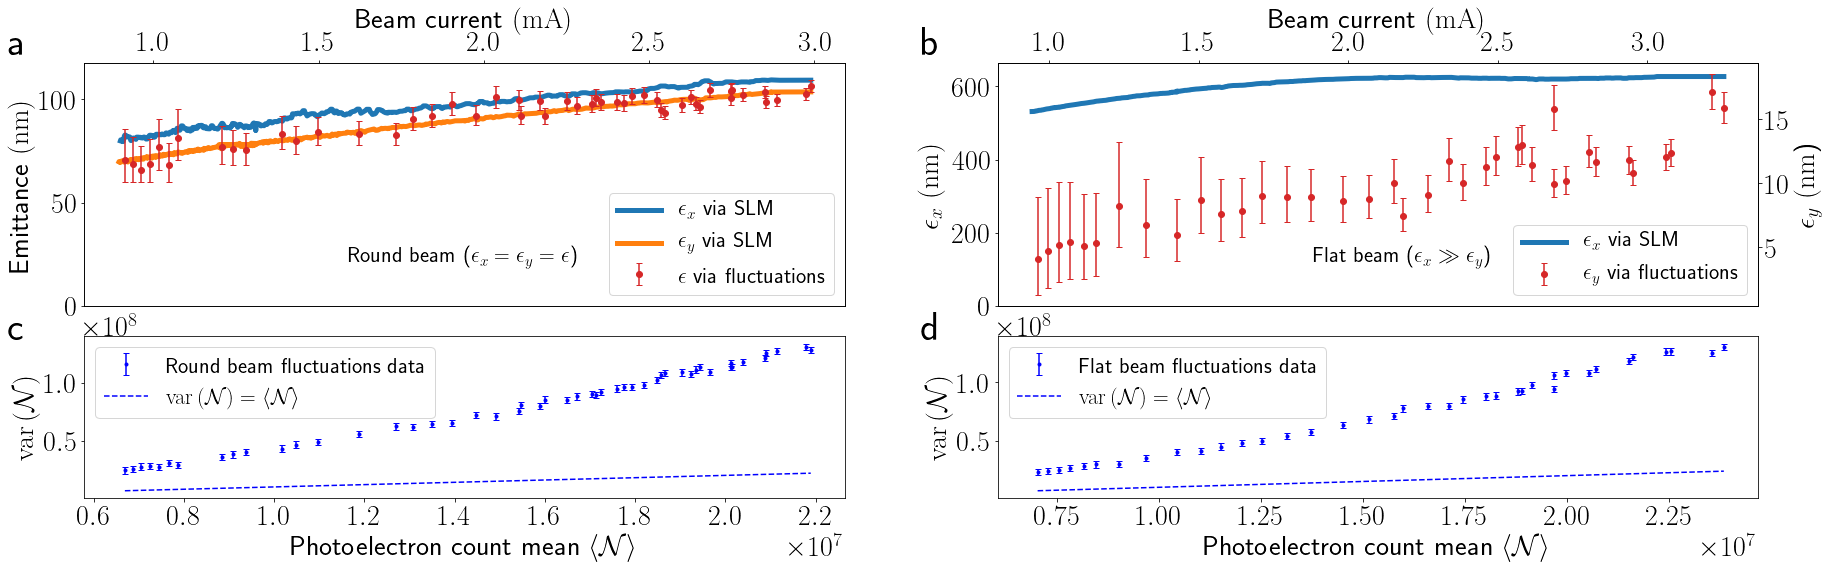

In [260]:
avNlabel = r"Photoelectron count mean $\langle\mathcal{N}\rangle$"
hybrid_balance_error = get_from_config("HybridBalanceError")
fit_errorbar = get_from_config("varN_error_fit")
df = round_df
plt.rcParams["text.usetex"] =True
plt.rc('text.latex', preamble=\
       r'\usepackage{siunitx}'
      +r'\newcommand{\e}{\epsilon}')
plt.rcParams.update({'figure.figsize':(30,8),
                     'font.size': 28,
                     'legend.fontsize':22,
                     'errorbar.capsize':3})
fs = 28



df = pd.concat([
    pd.DataFrame({'N:IWCMI_recalibrated_to_IWCMI_absolute':[-meas_ROUND['N'].max()/i_to_photoel],
                 'ex_um': ex_r_func(meas_ROUND['N'].max()),
                 'ey_um': ey_r_func(meas_ROUND['N'].max())
                 }),
    df], ignore_index=True)


i_to_photoel = cur_to_sum_channel*sum_channel_to_photoelectrons
fig, ax = plt.subplots(2,2, gridspec_kw={'height_ratios': [3, 2]})
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
ax[0][0].text(0.65, 0.15, r"Round beam ($\e_x=\e_y=\e$)", transform=ax[0][0].transAxes,
      fontsize=22, fontweight='bold', va='bottom', ha='right')
ax[0][0].plot(photoel.rolling(10).max(), 1000*df['ex_um'].rolling(4).max(),'-', linewidth=5 ,
        label=r'$\e_x$ via SLM')
ax[0][0].plot(photoel.rolling(4).max(), 1000*df['ey_um'],'-', linewidth=5 ,
        label=r'$\e_y$ via SLM')

ax[0][0].set_xlabel(r"Beam current $(\SI{}{mA})$", fontsize=fs)
ax[0][0].set_ylabel(r"Emittance $(\SI{}{nm})$", fontsize=fs)

color='tab:red'
yerr = 1e3*np.array([meas_ROUND['e_error_bottom'],meas_ROUND['e_error_top']])
#[meas_FLAT['Sigma_um_Y_Meas_Bottom'], meas_FLAT['Sigma_um_Y_Meas_Top']]
ax[0][0].errorbar(meas_ROUND['N'], 1e3*meas_ROUND['e_rec'],
             marker='o', linestyle='None',
             color=color, yerr=yerr, zorder=100,
             label=r"$\e$ via fluctuations")

ax[0][0].set_ylim(0, 1.05*ax[0][0].get_ylim()[1])
ax[0][0].get_xaxis().set_visible(False)
ax[0][0].legend(loc='lower right')
ax1 = ax[0][0].twiny()
ax1.set_xlabel(r"Beam current $(\SI{}{mA})$", fontsize=fs)
ax1.set_xlim(*[i/i_to_photoel for i in ax[0][0].get_xlim()])


hybrid_errorbar = 2*hybrid_balance_error\
    *np.absolute(res_df_ROUND_no_outliers['varN'])
error_bar = np.sqrt(0*hybrid_errorbar**2+fit_errorbar**2)
ax[1][0].errorbar(meas_ROUND['N'],meas_ROUND['varN'],
            marker='.',linestyle='None',yerr=error_bar,color='b',
            label = r'Round beam fluctuations data')
ax[1][0].plot(meas_ROUND['N'], meas_ROUND['N'],color='blue',linestyle='--',
        label = r"$\mathrm{var}\left(\mathcal{N}\right)=\langle\mathcal{N}\rangle$")
ax[1][0].set_ylabel(r"$\mathrm{var}\left(\mathcal{N}\right)$", fontsize=fs)
ax[1][0].set_xlabel(avNlabel, fontsize=fs)
handles, labels = ax[1][0].get_legend_handles_labels()
order = [1,0]
ax[1][0].legend([handles[idx] for idx in order],[labels[idx] for idx in order],
            loc='upper left')
ax[1][0].set_xlim(ax[0][0].get_xlim())
# plt.savefig(shift.get_results_dir().fi("flat_beam_ex_7_cameras.png"),
#             dpi=300, bbox_inches='tight')
# ax[1][0].get_yaxis().get_offset_text().set_x(-0.06)



ax[0][1].set_ylabel(r"$\e_x$ $(\SI{}{nm})$", fontsize=fs)

df = flat_df


# extrapolation:
df = pd.concat([
    pd.DataFrame({'N:IWCMI_recalibrated_to_IWCMI_absolute':[-meas_FLAT['N'].max()/i_to_photoel],
                 'ex_um': ex_f_func(meas_FLAT['N'].max())}),
    df], ignore_index=True)
photoel = i_to_photoel*(-df['N:IWCMI_recalibrated_to_IWCMI_absolute'])
ln1 = ax[0][1].plot(photoel.rolling(10).max(), 1000*df['ex_um'].rolling(4).max(),
                    '-', linewidth=5, label=r'$\e_x$ via SLM')
ax[0][1].set_ylim(0, 1.05*ax[0][1].get_ylim()[1])
ax[0][1].get_xaxis().set_visible(False)
ax[0][1].text(0.65, 0.15, r"Flat beam ($\e_x\gg\e_y$)", transform=ax[0][1].transAxes,
      fontsize=22, fontweight='bold', va='bottom', ha='right')
ax2 = ax[0][1].twiny()
ax2.set_xlabel(r"Beam current $(\SI{}{mA})$", fontsize=fs)
ax2.set_xlim(*[i/i_to_photoel for i in ax[0][1].get_xlim()])

ax3 = ax[0][1].twinx()
color='tab:red'
yerr = 1e3*np.array([meas_FLAT['ey_error_bottom'],meas_FLAT['ey_error_top']])
#[meas_FLAT['Sigma_um_Y_Meas_Bottom'], meas_FLAT['Sigma_um_Y_Meas_Top']]
ln2 = ax3.errorbar(meas_FLAT['N'], 1e3*meas_FLAT['ey_rec'],
             marker='o', linestyle='None',
             color=color, yerr=yerr, label=r'$\e_y$ via fluctuations')
ax3.set_ylabel(r"$\e_y$ $(\SI{}{nm}$)", fontsize=fs)

lns = [ln1[0], ln2]
labs = [l.get_label() for l in lns]
ax[0][1].legend(lns, labs, loc='lower right')



meas_FLAT = \
    pd.read_csv(shift.get_results_dir().fi('meas_FLAT_03_16_2020.csv'),
                index_col=0)
hybrid_errorbar = 2*hybrid_balance_error\
    *np.absolute(meas_FLAT['varN'])
error_bar = np.sqrt(0*hybrid_errorbar**2+fit_errorbar**2)
ax[1][1].errorbar(meas_FLAT['N'],meas_FLAT['varN'],
            marker='.',linestyle='None',yerr=error_bar,color='b',
            label = r'Flat beam fluctuations data')
ax[1][1].plot(meas_FLAT['N'], meas_FLAT['N'],color='blue',linestyle='--',
        label = r"$\mathrm{var}\left(\mathcal{N}\right)=\langle\mathcal{N}\rangle$")
ax[1][1].set_ylabel(r"$\mathrm{var}\left(\mathcal{N}\right)$", fontsize=fs)
ax[1][1].set_xlabel(avNlabel, fontsize=fs)
handles, labels = ax[1][1].get_legend_handles_labels()
order = [1,0]
ax[1][1].legend([handles[idx] for idx in order],[labels[idx] for idx in order],
            loc='upper left')
ax[1][1].set_xlim(ax[0][1].get_xlim())


fig.subplots_adjust(hspace=0.15)
for i, label in enumerate(('a', 'b', 'c', 'd')):
    x = i // 2
    y = i - 2*x
    axx = ax[x][y] 
    axx.text(-0.1, 1.15, label, transform=axx.transAxes,
      fontsize=40, fontweight='bold', va='top', ha='left')
print("Remember that a small protion of SLM data at large Ibeam is extrapolated")
plt.savefig(path_assistant.get_PRL_images_dir().fi("iota_measurements.png"),
            dpi=300, bbox_inches='tight')
plt.show()